In [4]:
import os
import glob
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm.auto import tqdm

/home/zhangzr/anaconda3/envs/mmseg-kaggle/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read csv and extract meta info

In [5]:
df_train = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
df_train = df_train.sort_values(["id", "class"]).reset_index(drop = True)
df_train["patient"] = df_train.id.apply(lambda x: x.split("_")[0])
df_train["days"] = df_train.id.apply(lambda x: "_".join(x.split("_")[:2]))

all_image_files = sorted(glob.glob("../input/uw-madison-gi-tract-image-segmentation/train/*/*/scans/*.png"), key = lambda x: x.split("/")[3] + "_" + x.split("/")[5])
size_x = [int(os.path.basename(_)[:-4].split("_")[-4]) for _ in all_image_files]
size_y = [int(os.path.basename(_)[:-4].split("_")[-3]) for _ in all_image_files]
spacing_x = [float(os.path.basename(_)[:-4].split("_")[-2]) for _ in all_image_files]
spacing_y = [float(os.path.basename(_)[:-4].split("_")[-1]) for _ in all_image_files]
df_train["image_files"] = np.repeat(all_image_files, 3)
df_train["spacing_x"] = np.repeat(spacing_x, 3)
df_train["spacing_y"] = np.repeat(spacing_y, 3)
df_train["size_x"] = np.repeat(size_x, 3)
df_train["size_y"] = np.repeat(size_y, 3)
df_train["slice"] = np.repeat([int(os.path.basename(_)[:-4].split("_")[-5]) for _ in all_image_files], 3)
df_train

,id,class,segmentation,patient,days,image_files,spacing_x,spacing_y,size_x,size_y,slice
0,case101_day20_slice_0001,large_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,28
1,case101_day20_slice_0001,small_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,28
2,case101_day20_slice_0001,stomach,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,28
3,case101_day20_slice_0002,large_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,129
4,case101_day20_slice_0002,small_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,129
...,...,...,...,...,...,...,...,...,...,...,...
115483,case9_day22_slice_0143,small_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,73
115484,case9_day22_slice_0143,stomach,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,73
115485,case9_day22_slice_0144,large_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,108
115486,case9_day22_slice_0144,small_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,108


# Make mmseg-format data (2.5D by default)

In [6]:
def rle_decode(mask_rle, shape):
    s = np.array(mask_rle.split(), dtype=int)
    starts, lengths = s[0::2] - 1, s[1::2]
    ends = starts + lengths
    h, w = shape
    img = np.zeros((h * w,), dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)

!mkdir -p ../data/mmseg_train_25d_new/{images,labels,splits}
for day, group in tqdm(df_train.groupby("days")):
    patient = group.patient.iloc[0]
    imgs = []
    msks = []
    file_names = []
    for file_name in group.image_files.unique():
        img = cv2.imread(file_name, cv2.IMREAD_ANYDEPTH)
        segms = group.loc[group.image_files == file_name]
        masks = {}
        for segm, label in zip(segms.segmentation, segms["class"]):
            if not pd.isna(segm):
                mask = rle_decode(segm, img.shape[:2])
                masks[label] = mask
            else:
                masks[label] = np.zeros(img.shape[:2], dtype = np.uint8)
        masks = np.stack([masks[k] for k in sorted(masks)], -1)
        imgs.append(img)
        msks.append(masks)
        
    imgs = np.stack(imgs, 0)
    msks = np.stack(msks, 0)
    for i in range(msks.shape[0]):
        img = imgs[[max(0, i - 2), i, min(imgs.shape[0] - 1, i + 2)]].transpose(1,2,0) # 2.5d data
        msk = msks[i]
        new_file_name = f"{day}_{i}.png"
        cv2.imwrite(f"../data/mmseg_train_25d_new/images/{new_file_name}", img)
        cv2.imwrite(f"../data/mmseg_train_25d_new/labels/{new_file_name}", msk)

  3%|▎         | 8/274 [00:11<06:27,  1.46s/it]


KeyboardInterrupt: 

# Make fold splits

In [ ]:
all_image_files = glob.glob("../data/mmseg_train_25d_new/images/*")
patients = [os.path.basename(_).split("_")[0] for _ in all_image_files]


from sklearn.model_selection import GroupKFold

split = list(GroupKFold(5).split(patients, groups = patients))

for fold, (train_idx, valid_idx) in enumerate(split):
    with open(f"../data/mmseg_train_25d_new/splits/fold_{fold}.txt", "w") as f:
        for idx in train_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")
    with open(f"../data/mmseg_train_25d_new/splits/holdout_{fold}.txt", "w") as f:
        for idx in valid_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")

# Check 2.5d data

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

[0 1]


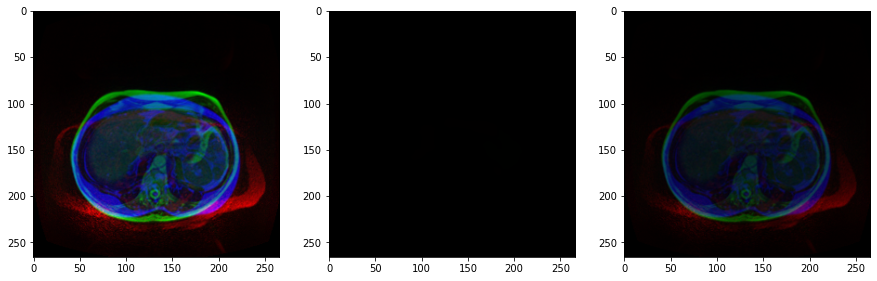

In [2]:
# check 2.5d data
IMAGE_DIR = '../data/mmseg_train_25d_new/images'
MASK_DIR = '../data/mmseg_train_25d_new/labels'
plt.figure(figsize=(15, 5))

imgs = cv2.imread(f'{IMAGE_DIR}/case143_day23_89.png', cv2.IMREAD_UNCHANGED).astype('float32')
imgs/=imgs.max(axis=(0,1))

plt.subplot(1, 3, 1)
plt.imshow(imgs)

msk = cv2.imread(f'{MASK_DIR}/case143_day23_89.png', cv2.IMREAD_UNCHANGED)
# msk/=255.0
print(np.unique(msk))

plt.subplot(1, 3, 2)
plt.imshow(msk)


plt.subplot(1, 3, 3)
plt.imshow(imgs)
plt.imshow(msk, alpha=0.5)